# Comparison of PPO and A2C in Multi-Agent Environment With Continuous Action Space

In [2]:
# utility imports
import os
import numpy as np
import pandas as pd

#env imports
import gym
from pettingzoo.sisl import multiwalker_v6
import supersuit as ss

#Algoritm Imports
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.a2c import MlpPolicy
from stable_baselines3 import PPO, A2C

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-idyf5iu5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
os.chdir('ppo_log')

In [4]:
env = multiwalker_v6.parallel_env(n_walkers=2, position_noise=1e-3, angle_noise=1e-3, local_ratio=1.0,
forward_reward=100.0, terminate_reward=-100.0, fall_reward=-10.0, terminate_on_fall=True, remove_on_fall=True,
max_cycles=500) #create env
agents= ['walker_0', 'walker_1'] #name agents

#env = ss.frame_stack_v1(env, 4)#stack 4 frames together to see velocity/direction
env = ss.pettingzoo_env_to_vec_env_v0(env) #convert to vec env
env = ss.concat_vec_envs_v0(env, 1, num_cpus=1, base_class='stable_baselines3') #parallelize

In [7]:
model_PPO = PPO(MlpPolicy, env, learning_rate=0.0003, n_steps=500, batch_size=200, n_epochs=10, gamma=0.99, gae_lambda=0.95, clip_range=0.2,
            clip_range_vf=1, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, use_sde=False, sde_sample_freq=- 1, target_kl=None, 
            tensorboard_log=None, create_eval_env=False, policy_kwargs=None, verbose=1, seed=314, device='auto', _init_setup_model=True)

Using cpu device


In [8]:
steps = [1,25000,50000,100000,200000]
#steps = [50000]
for step in steps:
    model_PPO.learn(total_timesteps = step)
    
    policy = str(step)
    model_PPO.save(policy)
    print(policy + ' complete!')

---------------------------------
| time/              |          |
|    fps             | 1149     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 1000     |
| train/             |          |
|    learning_rate   | 0.0003   |
---------------------------------
1 complete!
------------------------------------------
| time/                   |              |
|    fps                  | 1329         |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 1000         |
| train/                  |              |
|    approx_kl            | -0.038176525 |
|    clip_fraction        | 0.031        |
|    clip_range           | 0.2          |
|    clip_range_vf        | 1            |
|    entropy_loss         | -5.68        |
|    explained_variance   | 0.000229     |
|    learning_rate        | 0.0003       |
|    loss                 | 3.15e+03     |
|    n_updates            | 10       

In [15]:
results = pd.DataFrame(columns = ['num_training_steps', 'avg_reward'])

In [22]:
os.chdir('ppo_log')


In [23]:
num_episodes = range(100)

for count, filename in enumerate(os.listdir()):
    if filename.endswith(".zip"):
        model = PPO.load(filename.split('.')[0], env=env)
        reward_per_ep = []

        for ep in num_episodes:

            rewards = []
            steps = 0


            obs = env.reset()
            done = np.array([0,0])

            while all(done) != 1:
                action, _states = model.predict(obs)
                obs, reward, done, info = env.step(action)
                steps+=1
                rewards.append(reward[0])

            reward_per_ep.append(sum(rewards)/len(rewards))


        results = results.append({'num_training_steps' : int(filename.split('.')[0]), 'avg_reward' : sum(reward_per_ep)/len(reward_per_ep)}, ignore_index = True)

In [24]:
results.sort_values(by=['num_training_steps'])
results.to_csv('results_ppo.csv', index=False)

In [29]:
results.sort_values(by=['num_training_steps'])


,num_training_steps,avg_reward
0,1.0,0.658700
5,1.0,3.822702
4,25000.0,0.452377
9,25000.0,2.494338
1,50000.0,-0.093242
6,50000.0,2.839584
2,100000.0,0.255404
7,100000.0,1.693495
3,200000.0,2.224653
8,200000.0,5.369509


In [26]:
os.chdir('..')
os.chdir('a2c_log')

In [27]:
model_A2C = A2C(MlpPolicy, env, 
               learning_rate=0.0007, n_steps=5, gamma=0.99, gae_lambda=1.0, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5, rms_prop_eps=1e-05, 
                use_rms_prop=True, use_sde=False, sde_sample_freq=- 1, normalize_advantage=False,  tensorboard_log=None, 
                create_eval_env=False, policy_kwargs=None, verbose=0, seed=None, device='auto', _init_setup_model=True)

steps = [1,25000,50000,100000,200000]

for step in steps:
    model_PPO.learn(total_timesteps = step)
    
    policy = str(step)
    model_PPO.save(policy)
    print(policy + ' complete!')
    
num_episodes = range(10)

for count, filename in enumerate(os.listdir()):
    if filename.endswith(".zip"):
        model = PPO.load(filename.split('.')[0], env=env)
        reward_per_ep = []

        for ep in num_episodes:

            rewards = []
            steps = 0


            obs = env.reset()
            done = np.array([0,0])

            while all(done) != 1:
                action, _states = model.predict(obs)
                obs, reward, done, info = env.step(action)
                steps+=1
                rewards.append(reward[0])

            reward_per_ep.append(sum(rewards)/len(rewards))


        results = results.append({'num_training_steps' : int(filename.split('.')[0]), 'avg_reward' : sum(reward_per_ep)/len(reward_per_ep)}, ignore_index = True)

        
results.sort_values(by=['num_training_steps'])
results.to_csv('results_a2c.csv', index=False)

------------------------------------------
| time/                   |              |
|    fps                  | 1266         |
|    iterations           | 1            |
|    time_elapsed         | 0            |
|    total_timesteps      | 1000         |
| train/                  |              |
|    approx_kl            | -0.007924114 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    clip_range_vf        | 1            |
|    entropy_loss         | -5.69        |
|    explained_variance   | 0.488        |
|    learning_rate        | 0.0003       |
|    loss                 | 8.13e+03     |
|    n_updates            | 3760         |
|    policy_gradient_loss | 0.0003       |
|    std                  | 1.01         |
|    value_loss           | 1.49e+04     |
------------------------------------------
1 complete!
------------------------------------------
| time/                   |              |
|    fps                  | 1265         |

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
results_PPO_cont = pd.read_csv('results_ppo_cont.csv')
results_PPO_cont['algorithm'] = 'PPO'

results_A2C_cont = pd.read_csv('results_a2c_cont.csv')
results_A2C_cont['algorithm'] = 'A2C'

results_cont = pd.concat([results_PPO_cont, results_A2C_cont])

results_cont = results_cont.replace(1, 1000)

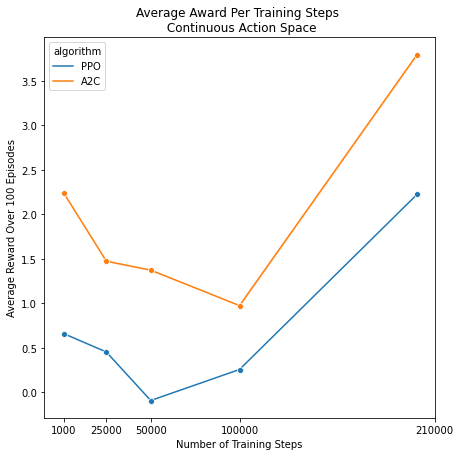

In [6]:
plt.figure(figsize=(7,7))
sns.lineplot(x=results_cont.num_training_steps, y=results_cont.avg_reward, hue=results_cont.algorithm, marker='o', ci=0);
plt.xlim(-10000, 200000.0)
plt.xticks([1000,25000,50000,100000,210000])
plt.title('Average Award Per Training Steps \n Continuous Action Space');
plt.xlabel('Number of Training Steps');
plt.ylabel('Average Reward Over 100 Episodes');